In [4]:
#!pip install aequitas==0.42.0 --quiet
#!pip install dataframe-image

## Importing Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aequitas.group import Group
from aequitas.bias import Bias
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from IPython.display import display
import dataframe_image as dfi

## Loading Data and Exploration

In [2]:
# Load data
df_preds = pd.read_csv("image_metadata.csv")
df_val = pd.read_csv("fairface_label_train.csv")

# Rename columns for consistency
df_preds.rename(columns={'file_path': 'file'}, inplace=True)

In [3]:
# Merge the validation and predictions data
df_merged = pd.merge(df_val, df_preds, on='file', how='inner')
print(df_merged.columns.tolist())

['file', 'age', 'gender', 'race', 'service_test', 'confidence']


In [4]:
# Desired category orders
gender_order = ["Male", "Female"]
race_order = ["White", "Latino_Hispanic", "Indian", "East Asian", "Black", "Southeast Asian", "Middle Eastern"]
age_order = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]

# Apply ordered categorical types to merged DataFrame
df_merged['age'] = pd.Categorical(df_merged['age'], categories=age_order, ordered=True)
df_merged['race'] = pd.Categorical(df_merged['race'], categories=race_order, ordered=True)
df_merged['gender'] = pd.Categorical(df_merged['gender'], categories=gender_order, ordered=True)

In [5]:
df_merged.head()

,file,age,gender,race,service_test,confidence
0,train/1.jpg,50-59,Male,East Asian,True,0.981539
1,train/2.jpg,30-39,Female,Indian,False,0.997358
2,train/3.jpg,3-9,Female,Black,False,0.998598
3,train/4.jpg,20-29,Female,Indian,True,0.996233
4,train/5.jpg,20-29,Female,Indian,True,0.999085


In [6]:
# Count occurrences of each category in the original merged dataset
total_gender_counts = df_merged['gender'].value_counts()
total_race_counts = df_merged['race'].value_counts()
total_age_counts = df_merged['age'].value_counts()

# Print the results
print("Total Gender Distribution:")
print(total_gender_counts)
print("\nTotal Race Distribution:")
print(total_race_counts)
print("\nTotal Age Distribution:")
print(total_age_counts)

Total Gender Distribution:
gender
Male      45986
Female    40758
Name: count, dtype: int64

Total Race Distribution:
race
White              16527
Latino_Hispanic    13367
Indian             12319
East Asian         12287
Black              12233
Southeast Asian    10795
Middle Eastern      9216
Name: count, dtype: int64

Total Age Distribution:
age
20-29           25598
30-39           19250
40-49           10744
3-9             10408
10-19            9103
50-59            6228
60-69            2779
0-2              1792
more than 70      842
Name: count, dtype: int64


## Threshold Setting for 95%, 90%, and 80% Confidence Predictions

In [7]:
# Coping the original DataFrame to a new one for 95% confidence threshold analysis
df_95_threshold = df_merged.copy()

# Appling the 95% confidence threshold to create a binary 'score' for Aequitas
df_95_threshold['score'] = df_95_threshold['confidence'].apply(lambda x: 1 if x >= 0.95 else 0)

# For Aequitas analysis, a 'label_value'column is needed for absolute truth
df_95_threshold['label_value'] = 1  # This assumes all entries should be faces

print(df_95_threshold[['file', 'confidence','score', 'label_value']].head())
print("Distribution of 'detected' status:")
print(df_95_threshold['score'].value_counts())

          file  confidence  score  label_value
0  train/1.jpg    0.981539      1            1
1  train/2.jpg    0.997358      1            1
2  train/3.jpg    0.998598      1            1
3  train/4.jpg    0.996233      1            1
4  train/5.jpg    0.999085      1            1
Distribution of 'detected' status:
score
1    79518
0     7226
Name: count, dtype: int64


In [8]:
# Coping the original DataFrame to a new one for 90% confidence threshold analysis
df_90_threshold = df_merged.copy()

# Appling the 90% confidence threshold to create a binary 'score' for Aequitas
df_90_threshold['score'] = df_90_threshold['confidence'].apply(lambda x: 1 if x >= 0.90 else 0)


# For Aequitas analysis, a 'label_value'column is needed for absolute truth
df_90_threshold['label_value'] = 1  # This assumes all entries should be faces

print(df_90_threshold[['file', 'confidence', 'score', 'label_value']].head())
print("Distribution of 'detected' status:")
print(df_90_threshold['score'].value_counts())

          file  confidence  score  label_value
0  train/1.jpg    0.981539      1            1
1  train/2.jpg    0.997358      1            1
2  train/3.jpg    0.998598      1            1
3  train/4.jpg    0.996233      1            1
4  train/5.jpg    0.999085      1            1
Distribution of 'detected' status:
score
1    83444
0     3300
Name: count, dtype: int64


In [9]:
# Coping the original DataFrame to a new one for 80% confidence threshold analysis

df_80_threshold = df_merged.copy()

# Appling the 80% confidence threshold to create a binary 'score' for Aequitas
df_80_threshold['score'] = df_80_threshold['confidence'].apply(lambda x: 1 if x >= 0.80 else 0)

# For Aequitas analysis, a 'label_value'column is needed for absolute truth
df_80_threshold['label_value'] = 1  # This assumes all entries should be faces

print(df_80_threshold[['file', 'confidence', 'score', 'label_value']].head())
print("Distribution of 'detected' status:")
print(df_80_threshold['score'].value_counts())

          file  confidence  score  label_value
0  train/1.jpg    0.981539      1            1
1  train/2.jpg    0.997358      1            1
2  train/3.jpg    0.998598      1            1
3  train/4.jpg    0.996233      1            1
4  train/5.jpg    0.999085      1            1
Distribution of 'detected' status:
score
1    85432
0     1312
Name: count, dtype: int64


## 95% Confidence Threshold Exploration

In [10]:
#### Quick analysis For 95% threshold
print("\nScore Analysis by Group:")
for group in ['gender', 'race', 'age']:
    print(f"\nGroup: {group}")
    print(df_95_threshold.groupby(group)['score'].agg(['mean', 'count', 'std']))
    
print("\nLabel Value Analysis by Group:")
for group in ['gender', 'race', 'age']:
    print(f"\nGroup: {group}")
    print(df_95_threshold.groupby(group)['label_value'].agg(['mean', 'count', 'std']))

print("\nScore Value Counts by Gender, Race, and Age:")
print(df_95_threshold.groupby(['gender', 'race', 'age'])
      ['score'].value_counts(normalize=True))


Score Analysis by Group:

Group: gender
            mean  count       std
gender                           
Male    0.905210  45986  0.292927
Female  0.929658  40758  0.255726

Group: race
                     mean  count       std
race                                      
White            0.899619  16527  0.300517
Latino_Hispanic  0.929079  13367  0.256702
Indian           0.933030  12319  0.249980
East Asian       0.917067  12287  0.275792
Black            0.894384  12233  0.307358
Southeast Asian  0.935063  10795  0.246427
Middle Eastern   0.915148   9216  0.278677

Group: age
                  mean  count       std
age                                    
0-2           0.920201   1792  0.271058
3-9           0.942736  10408  0.232357
10-19         0.934966   9103  0.246599
20-29         0.922025  25598  0.268137
30-39         0.906494  19250  0.291148
40-49         0.898920  10744  0.301448
50-59         0.897238   6228  0.303672
60-69         0.895286   2779  0.306240
more than 7

In [11]:
# Filter for undetected faces 95% threshold
undetected_df_95 = df_95_threshold[df_95_threshold['score'] == 0]

# Count occurrences of each category within undetected faces
undetected_gender_counts_95 = undetected_df_95['gender'].value_counts()
undetected_race_counts_95 = undetected_df_95['race'].value_counts()
undetected_age_counts_95 = undetected_df_95['age'].value_counts()

# Print the results
print("Undetected Gender Distribution:")
print(undetected_gender_counts_95)
print("\nUndetected Race Distribution:")
print(undetected_race_counts_95)
print("\nUndetected Age Distribution:")
print(undetected_age_counts_95)

Undetected Gender Distribution:
gender
Male      4359
Female    2867
Name: count, dtype: int64

Undetected Race Distribution:
race
White              1659
Black              1292
East Asian         1019
Latino_Hispanic     948
Indian              825
Middle Eastern      782
Southeast Asian     701
Name: count, dtype: int64

Undetected Age Distribution:
age
20-29           1996
30-39           1800
40-49           1086
50-59            640
3-9              596
10-19            592
60-69            291
0-2              143
more than 70      82
Name: count, dtype: int64


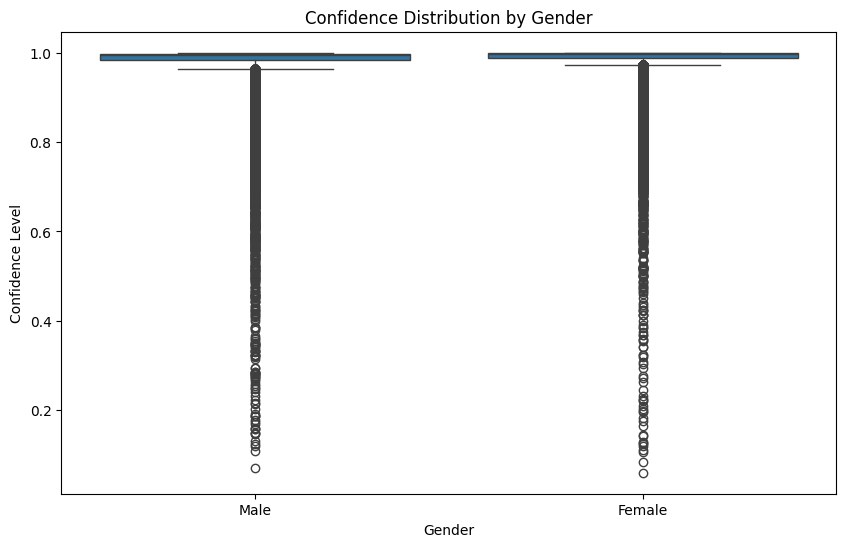

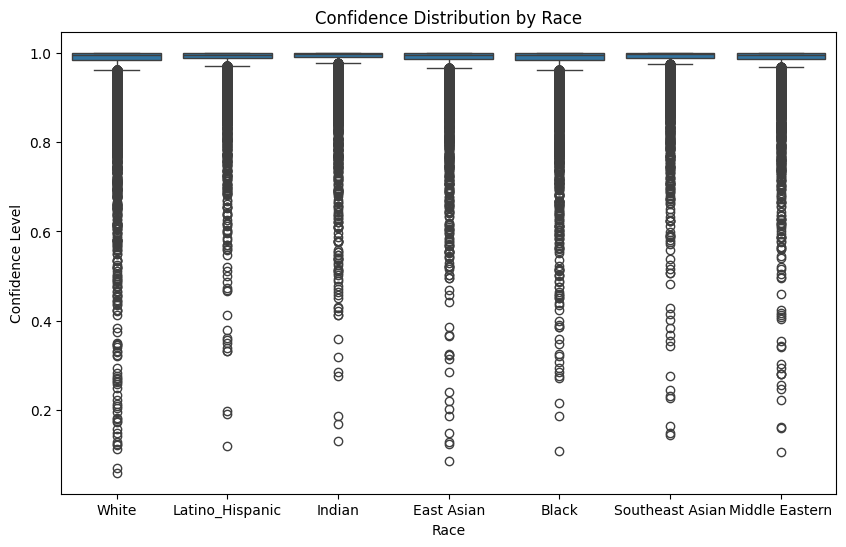

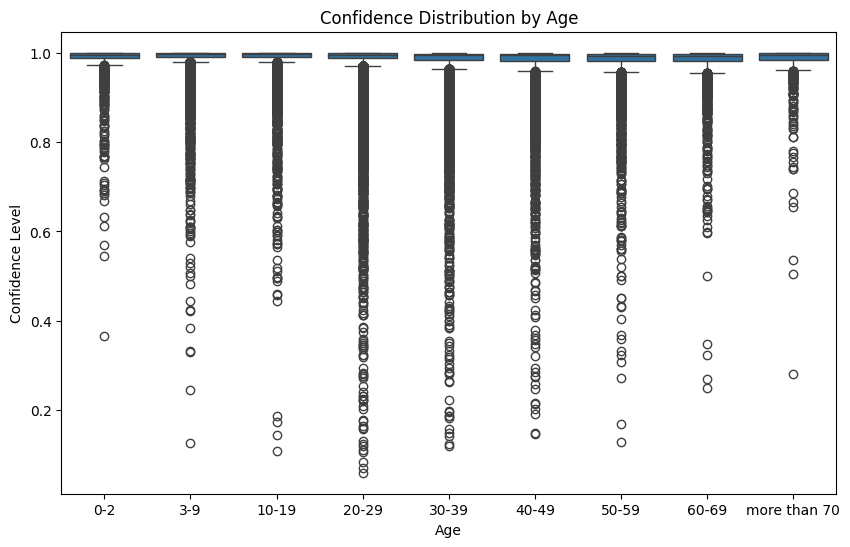

In [12]:
# Boxplt for predictions csv

for group in ['gender', 'race', 'age']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group, y='confidence', data=df_merged)
    plt.title(f'Confidence Distribution by {group.capitalize()}')
    plt.xlabel(group.capitalize())
    plt.ylabel('Confidence Level')
    plt.show()

## 90% Confidence Threshold Exploration

In [13]:
# Quick analysis For 90% threshold

print("\nScore Analysis by Group:")
for group in ['gender', 'race', 'age']:
    print(f"\nGroup: {group}")
    print(df_90_threshold.groupby(group)['score'].agg(['mean', 'count', 'std']))
    
print("\nLabel Value Analysis by Group:")
for group in ['gender', 'race', 'age']:
    print(f"\nGroup: {group}")
    print(df_90_threshold.groupby(group)['label_value'].agg(['mean', 'count', 'std']))

print("\nScore Value Counts by Gender, Race, and Age:")
print(df_90_threshold.groupby(['gender', 'race', 'age'])
      ['score'].value_counts(normalize=True))


Score Analysis by Group:

Group: gender
            mean  count       std
gender                           
Male    0.956726  45986  0.203476
Female  0.967859  40758  0.176376

Group: race
                     mean  count       std
race                                      
White            0.953289  16527  0.211026
Latino_Hispanic  0.970225  13367  0.169972
Indian           0.968342  12319  0.175096
East Asian       0.964271  12287  0.185621
Black            0.949644  12233  0.218687
Southeast Asian  0.971283  10795  0.167018
Middle Eastern   0.959310   9216  0.197582

Group: age
                  mean  count       std
age                                    
0-2           0.965960   1792  0.181383
3-9           0.973962  10408  0.159255
10-19         0.971108   9103  0.167511
20-29         0.961677  25598  0.191979
30-39         0.957351  19250  0.202071
40-49         0.954207  10744  0.209046
50-59         0.957771   6228  0.201127
60-69         0.958618   2779  0.199207
more than 7

In [14]:
# Filter for undetected faces 90% threshold
undetected_df_90 = df_90_threshold[df_90_threshold['score'] == 0]

# Count occurrences of each category within undetected faces
undetected_gender_counts_90 = undetected_df_90['gender'].value_counts()
undetected_race_counts_90 = undetected_df_90['race'].value_counts()
undetected_age_counts_90 = undetected_df_90['age'].value_counts()

# Print the results
print("Undetected Gender Distribution:")
print(undetected_gender_counts_90)
print("\nUndetected Race Distribution:")
print(undetected_race_counts_90)
print("\nUndetected Age Distribution:")
print(undetected_age_counts_90)

Undetected Gender Distribution:
gender
Male      1990
Female    1310
Name: count, dtype: int64

Undetected Race Distribution:
race
White              772
Black              616
East Asian         439
Latino_Hispanic    398
Indian             390
Middle Eastern     375
Southeast Asian    310
Name: count, dtype: int64

Undetected Age Distribution:
age
20-29           981
30-39           821
40-49           492
3-9             271
10-19           263
50-59           263
60-69           115
0-2              61
more than 70     33
Name: count, dtype: int64


## 80% Confidence Threshold Exploration

In [15]:
# Quick analysis For 80% threshold

for group in ['gender', 'race', 'age']:
    print(df_80_threshold.groupby(group)['score'].agg(['mean', 'count', 'std']))
    
for group in ['gender', 'race', 'age']:
    print(df_80_threshold.groupby(group)['label_value'].agg(['mean', 'count', 'std']))

print(df_80_threshold.groupby(['gender', 'race', 'age'])['score'].value_counts(normalize=True))

            mean  count       std
gender                           
Male    0.982538  45986  0.130986
Female  0.987512  40758  0.111053
                     mean  count       std
race                                      
White            0.980214  16527  0.139268
Latino_Hispanic  0.990125  13367  0.098885
Indian           0.986606  12319  0.114959
East Asian       0.985595  12287  0.119160
Black            0.979400  12233  0.142047
Southeast Asian  0.989069  10795  0.103983
Middle Eastern   0.984701   9216  0.122748
                  mean  count       std
age                                    
0-2           0.984375   1792  0.124054
3-9           0.990968  10408  0.094609
10-19         0.988905   9103  0.104754
20-29         0.984178  25598  0.124787
30-39         0.982805  19250  0.130000
40-49         0.982781  10744  0.130092
50-59         0.982498   6228  0.131141
60-69         0.983447   2779  0.127611
more than 70  0.984561    842  0.123366
        mean  count  std
gender      

In [16]:
# Filter for undetected faces 80% threshold
undetected_df_80 = df_80_threshold[df_80_threshold['score'] == 0]

# Count occurrences of each category within undetected faces
undetected_gender_counts_80 = undetected_df_80['gender'].value_counts()
undetected_race_counts_80 = undetected_df_80['race'].value_counts()
undetected_age_counts_80 = undetected_df_80['age'].value_counts()

# Print the results
print("Undetected Gender Distribution:")
print(undetected_gender_counts_80)
print("\nUndetected Race Distribution:")
print(undetected_race_counts_80)
print("\nUndetected Age Distribution:")
print(undetected_age_counts_80)

Undetected Gender Distribution:
gender
Male      803
Female    509
Name: count, dtype: int64

Undetected Race Distribution:
race
White              327
Black              252
East Asian         177
Indian             165
Middle Eastern     141
Latino_Hispanic    132
Southeast Asian    118
Name: count, dtype: int64

Undetected Age Distribution:
age
20-29           405
30-39           331
40-49           185
50-59           109
10-19           101
3-9              94
60-69            46
0-2              28
more than 70     13
Name: count, dtype: int64


## Aequitas Evaluation

In [17]:

def calculate_aequitas_metrics(df, label):
    print(f"\nAequitas Metrics for {label} Threshold:")
    
    # Change columns to string type for Aequitas
    for col in ['gender', 'race', 'age']:
        df[col] = df[col].astype(str)
    
    # Create the Group object and compute the crosstabs
    g = Group()
    xtab, _ = g.get_crosstabs(df, attr_cols=['gender', 'race', 'age'])
    
    # Create the Bias object and compute disparity
    b = Bias()
    bias = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict={
    'gender': 'Male',  # Using 'Male' as reference for gender
    'race': 'White',   # Using 'White' as reference for race
    'age': '20-29'     # Using '20-29' as reference for age
        }, alpha=0.05)

    # Print xtab
    print("\nCrosstab:")
    xtab_cols = ['attribute_name', 'attribute_value', 'pprev', 'ppr', 'fpr', 'fnr', 'fpr_disparity', 'fnr_disparity']
    print(xtab[xtab.columns.intersection(xtab_cols)])

    # Print bias disparities
    print("\nBias Disparities:")
    bias_cols = ['attribute_name', 'attribute_value', 'fpr_disparity', 'fnr_disparity', 'for_disparity', 'fdr_disparity', 'tpr_disparity', 'tnr_disparity']
    print(bias[bias.columns.intersection(bias_cols)])

# Apply the function to each threshold DataFrame
threshold_dfs = [
    (df_95_threshold, "95%"),
    (df_90_threshold, "90%"),
    (df_80_threshold, "80%")
]

for df, label in threshold_dfs:
    calculate_aequitas_metrics(df, label)



Aequitas Metrics for 95% Threshold:
get_disparity_predefined_group()

Crosstab:
   attribute_name  attribute_value  fpr       fnr       ppr     pprev
0          gender           Female  NaN  0.070342  0.476508  0.929658
1          gender             Male  NaN  0.094790  0.523492  0.905210
2            race            Black  NaN  0.105616  0.137591  0.894384
3            race       East Asian  NaN  0.082933  0.141704  0.917067
4            race           Indian  NaN  0.066970  0.144546  0.933030
5            race  Latino_Hispanic  NaN  0.070921  0.156178  0.929079
6            race   Middle Eastern  NaN  0.084852  0.106064  0.915148
7            race  Southeast Asian  NaN  0.064937  0.126940  0.935063
8            race            White  NaN  0.100381  0.186977  0.899619
9             age              0-2  NaN  0.079799  0.020737  0.920201
10            age            10-19  NaN  0.065034  0.107032  0.934966
11            age            20-29  NaN  0.077975  0.296813  0.922025
12       

In [18]:
def calculate_aequitas_metrics(df, label):
    print(f"\nAequitas Metrics for {label} Threshold:")

    # Change columns to string type for Aequitas
    for col in ['gender', 'race', 'age']:
        df[col] = df[col].astype(str)

    # Create the Group object and compute the crosstabs
    g = Group()
    xtab, _ = g.get_crosstabs(df, attr_cols=['gender', 'race', 'age'])

    # Create the Bias object and compute disparity
    b = Bias()
    bias = b.get_disparity_predefined_groups(
        xtab,
        original_df=df,
        ref_groups_dict={
            'gender': 'Male',
            'race': 'White',
            'age': '20-29'
        },
        alpha=0.05
    )

    # Select columns that actually exist
    xtab_cols = ['attribute_name', 'attribute_value', 'pprev', 'ppr', 'fnr']
    bias_cols = ['attribute_name', 'attribute_value', 'fnr_disparity', 'for_disparity', 'tpr_disparity']

    # Crosstab (only show available columns)
    print("\nCrosstab:")
    display(
        xtab[xtab_cols]
        .style
        .format(precision=4)
        .set_caption(f"Aequitas Crosstab ({label} Threshold)")
        .background_gradient(cmap='Blues', subset=['fnr'])  # only 'fnr' exists here
        .set_properties(**{'border': '1px solid black', 'padding': '5px'})
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '14pt'), ('font-weight', 'bold')]}
        ])
    )

    # Bias disparities (use disparities columns)
    print("\nBias Disparities:")
    display(
        bias[bias_cols]
        .style
        .format(precision=4)
        .set_caption(f"Aequitas Bias Disparities ({label} Threshold)")
        .background_gradient(cmap='Oranges', subset=['fnr_disparity'])  # 'fnr_disparity' only exists here
        .set_properties(**{'border': '1px solid black', 'padding': '5px'})
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '14pt'), ('font-weight', 'bold')]}
        ])
    )
    return xtab[xtab_cols], bias[bias_cols]
    
# Run for each threshold
threshold_dfs = [
    (df_95_threshold, "95%"),
    (df_90_threshold, "90%"),
    (df_80_threshold, "80%")
]

for df, label in threshold_dfs:
    xtab_result, bias_result = calculate_aequitas_metrics(df, label)


Aequitas Metrics for 95% Threshold:
get_disparity_predefined_group()

Crosstab:


,attribute_name,attribute_value,pprev,ppr,fnr
0,gender,Female,0.9297,0.4765,0.0703
1,gender,Male,0.9052,0.5235,0.0948
2,race,Black,0.8944,0.1376,0.1056
3,race,East Asian,0.9171,0.1417,0.0829
4,race,Indian,0.9330,0.1445,0.0670
5,race,Latino_Hispanic,0.9291,0.1562,0.0709
6,race,Middle Eastern,0.9151,0.1061,0.0849
7,race,Southeast Asian,0.9351,0.1269,0.0649
8,race,White,0.8996,0.1870,0.1004
9,age,0-2,0.9202,0.0207,0.0798



Bias Disparities:


,attribute_name,attribute_value,fnr_disparity,for_disparity,tpr_disparity
0,gender,Female,0.7421,1.0000,1.0270
1,gender,Male,1.0000,1.0000,1.0000
2,race,Black,1.0521,1.0000,0.9942
3,race,East Asian,0.8262,1.0000,1.0194
4,race,Indian,0.6672,1.0000,1.0371
5,race,Latino_Hispanic,0.7065,1.0000,1.0327
6,race,Middle Eastern,0.8453,1.0000,1.0173
7,race,Southeast Asian,0.6469,1.0000,1.0394
8,race,White,1.0000,1.0000,1.0000
9,age,0-2,1.0234,1.0000,0.9980



Aequitas Metrics for 90% Threshold:
get_disparity_predefined_group()

Crosstab:


,attribute_name,attribute_value,pprev,ppr,fnr
0,gender,Female,0.9679,0.4727,0.0321
1,gender,Male,0.9567,0.5273,0.0433
2,race,Black,0.9496,0.1392,0.0504
3,race,East Asian,0.9643,0.1420,0.0357
4,race,Indian,0.9683,0.1430,0.0317
5,race,Latino_Hispanic,0.9702,0.1554,0.0298
6,race,Middle Eastern,0.9593,0.1060,0.0407
7,race,Southeast Asian,0.9713,0.1257,0.0287
8,race,White,0.9533,0.1888,0.0467
9,age,0-2,0.9660,0.0207,0.0340



Bias Disparities:


,attribute_name,attribute_value,fnr_disparity,for_disparity,tpr_disparity
0,gender,Female,0.7427,1.0000,1.0116
1,gender,Male,1.0000,1.0000,1.0000
2,race,Black,1.0780,1.0000,0.9962
3,race,East Asian,0.7649,1.0000,1.0115
4,race,Indian,0.6777,1.0000,1.0158
5,race,Latino_Hispanic,0.6374,1.0000,1.0178
6,race,Middle Eastern,0.8711,1.0000,1.0063
7,race,Southeast Asian,0.6148,1.0000,1.0189
8,race,White,1.0000,1.0000,1.0000
9,age,0-2,0.8882,1.0000,1.0045



Aequitas Metrics for 80% Threshold:
get_disparity_predefined_group()

Crosstab:


,attribute_name,attribute_value,pprev,ppr,fnr
0,gender,Female,0.9875,0.4711,0.0125
1,gender,Male,0.9825,0.5289,0.0175
2,race,Black,0.9794,0.1402,0.0206
3,race,East Asian,0.9856,0.1418,0.0144
4,race,Indian,0.9866,0.1423,0.0134
5,race,Latino_Hispanic,0.9901,0.1549,0.0099
6,race,Middle Eastern,0.9847,0.1062,0.0153
7,race,Southeast Asian,0.9891,0.1250,0.0109
8,race,White,0.9802,0.1896,0.0198
9,age,0-2,0.9844,0.0206,0.0156



Bias Disparities:


,attribute_name,attribute_value,fnr_disparity,for_disparity,tpr_disparity
0,gender,Female,0.7152,1.0000,1.0051
1,gender,Male,1.0000,1.0000,1.0000
2,race,Black,1.0412,1.0000,0.9992
3,race,East Asian,0.7281,1.0000,1.0055
4,race,Indian,0.6769,1.0000,1.0065
5,race,Latino_Hispanic,0.4991,1.0000,1.0101
6,race,Middle Eastern,0.7733,1.0000,1.0046
7,race,Southeast Asian,0.5525,1.0000,1.0090
8,race,White,1.0000,1.0000,1.0000
9,age,0-2,0.9876,1.0000,1.0002


In [19]:
def calculate_and_save_aequitas_metrics(df, label):
    print(f"\nCalculating Aequitas Metrics for {label} Threshold...")

    # Change columns to string type
    for col in ['gender', 'race', 'age']:
        df[col] = df[col].astype(str)

    # Aequitas Group and Bias Calculations
    g = Group()
    xtab, _ = g.get_crosstabs(df, attr_cols=['gender', 'race', 'age'])

    b = Bias()
    bias = b.get_disparity_predefined_groups(
        xtab,
        original_df=df,
        ref_groups_dict={
            'gender': 'Male',
            'race': 'White',
            'age': '20-29'
        },
        alpha=0.05
    )

    # Columns to keep
    xtab_cols = ['attribute_name', 'attribute_value', 'pprev', 'ppr', 'fnr']
    bias_cols = ['attribute_name', 'attribute_value', 'fnr_disparity', 'for_disparity', 'tpr_disparity']

    # Format Crosstab
    xtab_styled = xtab[xtab_cols]\
        .style\
        .format(precision=4)\
        .set_caption(f"Aequitas Crosstab ({label} Threshold)")\
        .background_gradient(cmap='Blues', subset=['fnr'])\
        .set_properties(**{'border': '1px solid black', 'padding': '5px'})\
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '14pt'), ('font-weight', 'bold')]}
        ])

    # Format Bias Table
    bias_styled = bias[bias_cols]\
        .style\
        .format(precision=4)\
        .set_caption(f"Aequitas Bias Disparities ({label} Threshold)")\
        .background_gradient(cmap='Oranges', subset=['fnr_disparity'])\
        .set_properties(**{'border': '1px solid black', 'padding': '5px'})\
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
            {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '14pt'), ('font-weight', 'bold')]}
        ])

    # Save HTML files in same folder
    xtab_styled.to_html(f"aequitas_crosstab_{label.replace('%', '')}.html")
    bias_styled.to_html(f"aequitas_bias_{label.replace('%', '')}.html")

    print(f" Saved Crosstab and Bias tables for {label} threshold next to notebook.")


threshold_dfs = [
    (df_95_threshold, "95%"),
    (df_90_threshold, "90%"),
    (df_80_threshold, "80%")
]

for df, label in threshold_dfs:
    calculate_and_save_aequitas_metrics(df, label)


Calculating Aequitas Metrics for 95% Threshold...
get_disparity_predefined_group()
 Saved Crosstab and Bias tables for 95% threshold next to notebook.

Calculating Aequitas Metrics for 90% Threshold...
get_disparity_predefined_group()
 Saved Crosstab and Bias tables for 90% threshold next to notebook.

Calculating Aequitas Metrics for 80% Threshold...
get_disparity_predefined_group()
 Saved Crosstab and Bias tables for 80% threshold next to notebook.


## AUC Curve

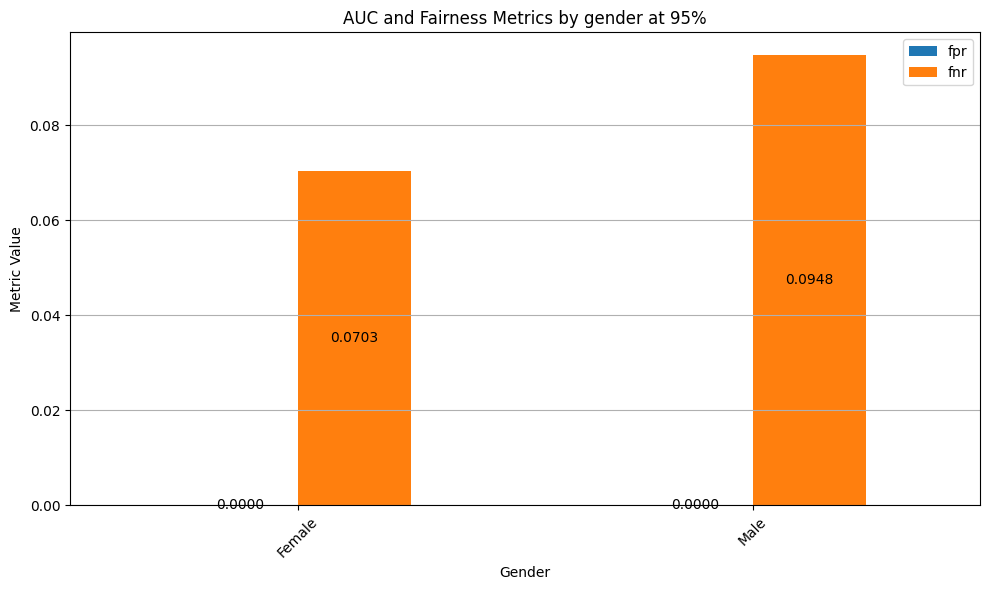

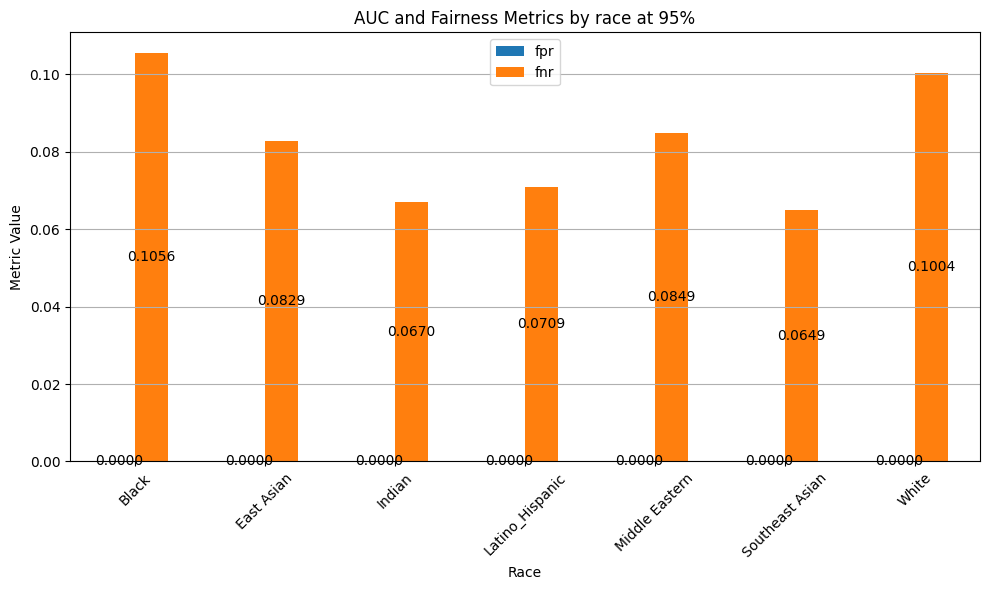

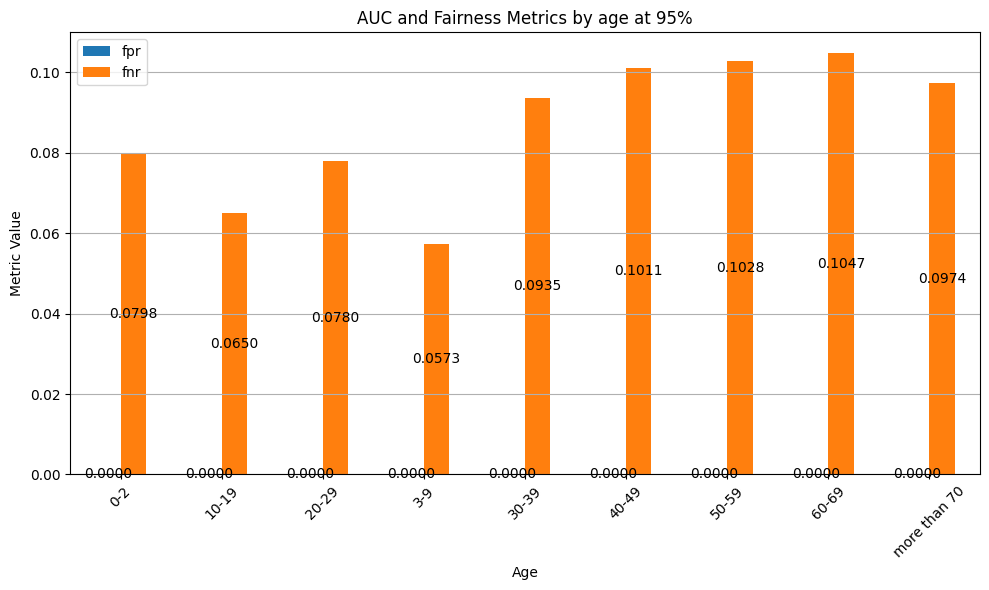

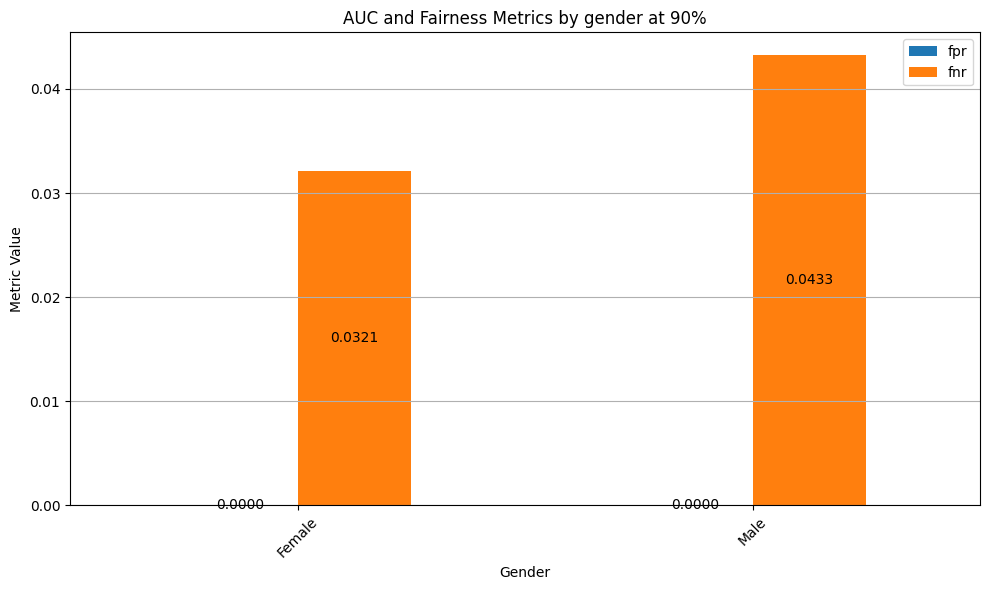

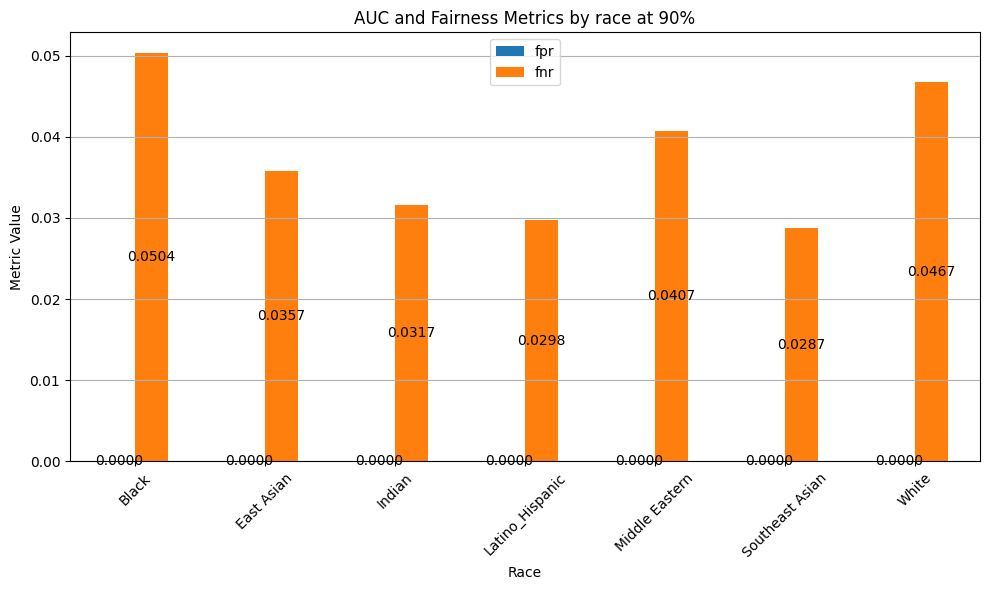

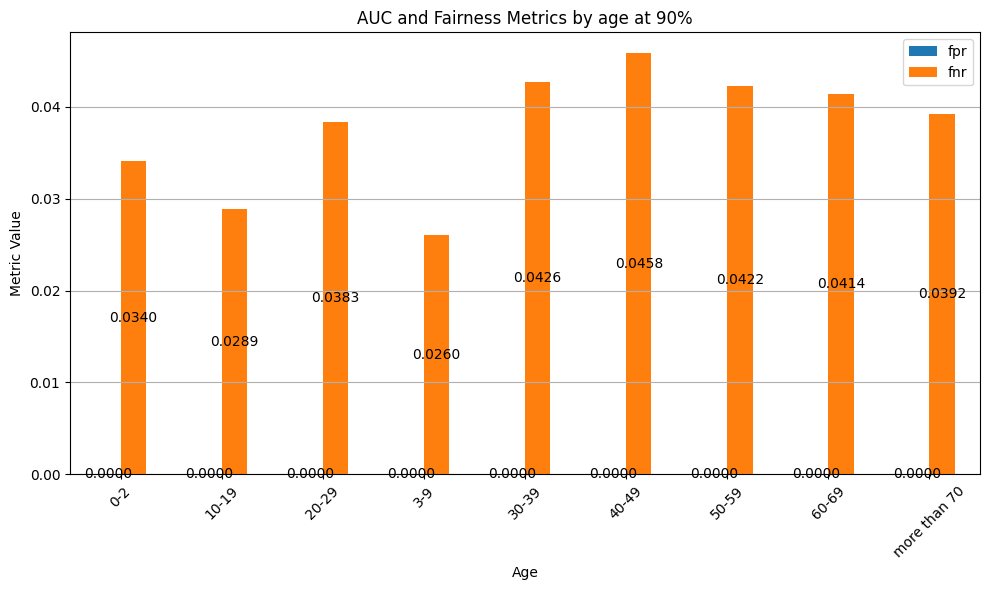

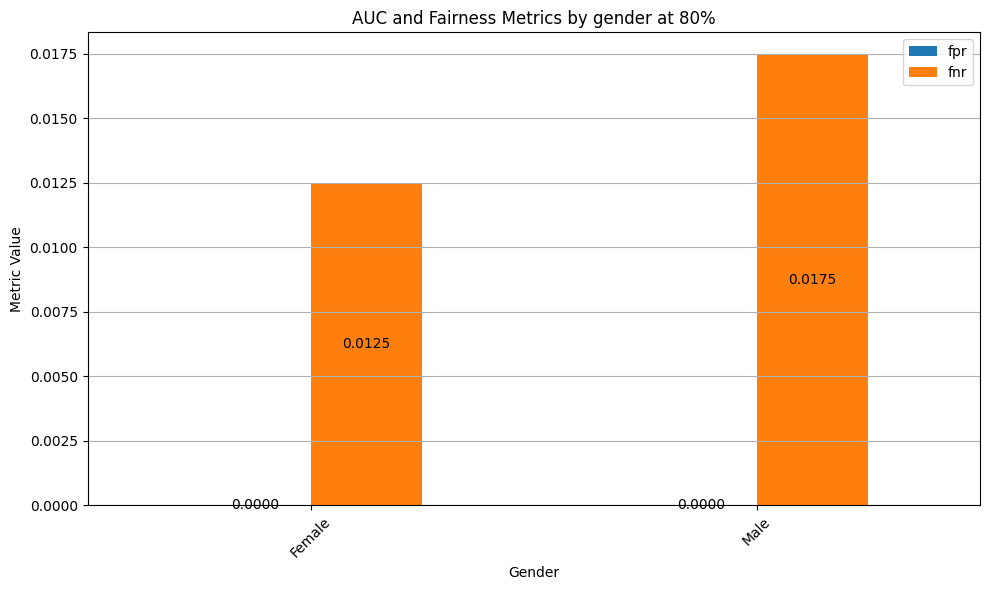

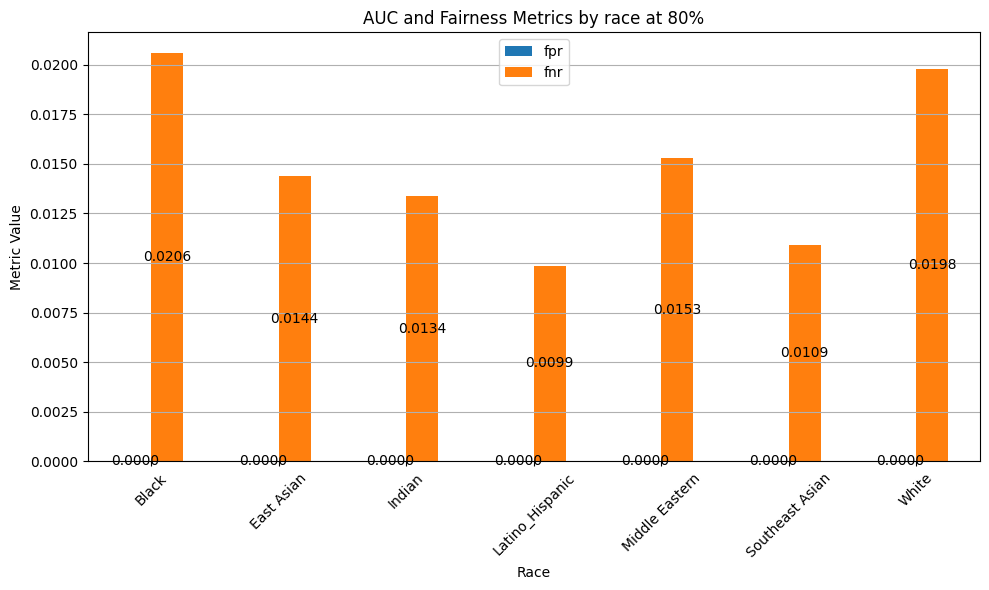

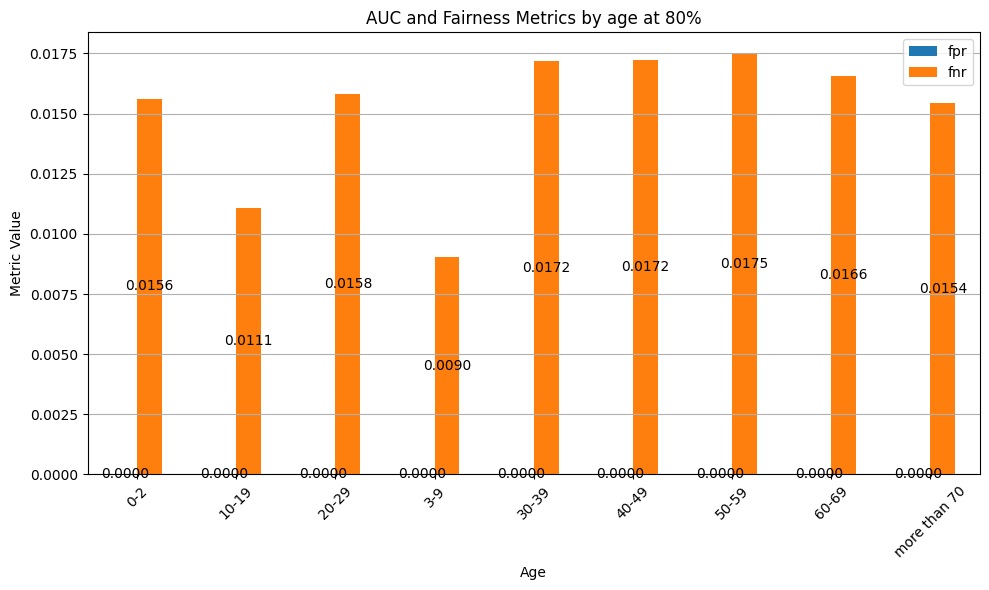

In [20]:
# Function to compute AUC and plot for each threshold
def compute_and_plot_auc(df, threshold_label):
    
    # Change columns to string type for Auc Curve    
    for col in ['gender', 'race', 'age']:
        df[col] = df[col].astype(str)
    
    # Create the Group object and compute the crosstabs
    g = Group()
    xtab, _ = g.get_crosstabs(df, attr_cols=['gender', 'race', 'age'])

    for group in ['gender', 'race', 'age']:
        plt.figure(figsize=(10, 6))
        xtab_group = xtab[xtab['attribute_name'] == group].set_index('attribute_value')

        # Compute AUC for each group
        auc_dict = {}
        for val, subset in df.groupby(group):
            if subset['label_value'].nunique() < 2:
                auc_dict[val] = None  # Cannot compute AUC with only one class present
            else:
                auc_dict[val] = roc_auc_score(subset['label_value'], subset['score'])

        # Create DataFrame from AUC dictionary
        auc_df = pd.DataFrame.from_dict(auc_dict, orient='index', columns=['auc'])

        # Combine FPR, FNR and AUC into one DataFrame
        group_data = xtab_group[['fpr', 'fnr']].join(auc_df)

        # Plot
        ax = group_data.plot(kind='bar', title=f'AUC and Fairness Metrics by {group} at {threshold_label}', ax=plt.gca())
        plt.ylabel('Metric Value')
        plt.xlabel(group.capitalize())
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()

        # Adding labels to each bar
        for container in ax.containers:
            ax.bar_label(container, fmt='%.4f', label_type='center')

        plt.show()

# Apply the function to each threshold DataFrame
threshold_dfs = [
    (df_95_threshold, "95%"),
    (df_90_threshold, "90%"),
    (df_80_threshold, "80%")
]

for df, label in threshold_dfs:
    compute_and_plot_auc(df, label)

In [22]:
# Function to compute and SAVE AUC plots for each threshold
def compute_and_save_auc_unbal(df, threshold_label):
    
    # Convert columns to string type
    for col in ['gender', 'race', 'age']:
        df[col] = df[col].astype(str)

    # Generate group crosstabs
    g = Group()
    xtab, _ = g.get_crosstabs(df, attr_cols=['gender', 'race', 'age'])

    for group in ['gender', 'race', 'age']:
        plt.figure(figsize=(10, 6))
        xtab_group = xtab[xtab['attribute_name'] == group].set_index('attribute_value')

        # Compute AUC per group
        auc_dict = {}
        for val, subset in df.groupby(group):
            if subset['label_value'].nunique() < 2:
                auc_dict[val] = None
            else:
                auc_dict[val] = roc_auc_score(subset['label_value'], subset['score'])

        # Combine into a single DataFrame
        auc_df = pd.DataFrame.from_dict(auc_dict, orient='index', columns=['auc'])
        group_data = xtab_group[['fpr', 'fnr']].join(auc_df)

        # Plot
        ax = group_data.plot(kind='bar', title=f'AUC and Fairness Metrics by {group.capitalize()} at {threshold_label} (Unbalanced)', ax=plt.gca())
        plt.ylabel('Metric Value')
        plt.xlabel(group.capitalize())
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()

        # Label bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.4f', label_type='center')

        # Save as PNG
        plt.savefig(f"auc_curve_{group}_{threshold_label.replace('%', '')}.png", dpi=300)
        plt.close()

    print(f" Saved AUC plots for {threshold_label} threshold!")


threshold_dfs_unbal = [
    (df_95_threshold, "95%"),
    (df_90_threshold, "90%"),
    (df_80_threshold, "80%")
]

for df, label in threshold_dfs_unbal:
    compute_and_save_auc_unbal(df, label)

 Saved AUC plots for 95% threshold!
 Saved AUC plots for 90% threshold!
 Saved AUC plots for 80% threshold!
